# Kidney Stone Classication using CT_Images

## Importing Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import gradio as gr

## Preparing Traning Data

,filename,category
0,Normal\Normal- (10).jpg,Normal
1,Normal\Normal- (100).jpg,Normal
2,Normal\Normal- (1000).jpg,Normal
3,Normal\Normal- (1004).jpg,Normal
4,Normal\Normal- (1005).jpg,Normal


,filename,category
4535,Stone\Stone- (995).jpg,Stone
4536,Stone\Stone- (996).jpg,Stone
4537,Stone\Stone- (997).jpg,Stone
4538,Stone\Stone- (998).jpg,Stone
4539,Stone\Stone- (999).jpg,Stone


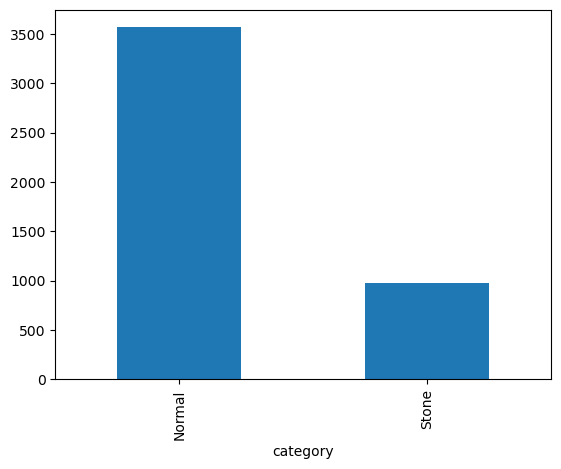

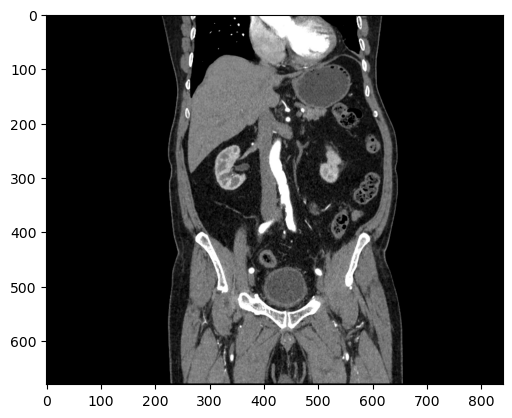

In [159]:
folder_path = "OneDrive/Documents/kidnee/CT_SCAN/Train"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)

    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
display(df.head())
display(df.tail())
df['category'].value_counts().plot.bar()
plt.show()
sample = random.choice(filenames)
image = load_img("OneDrive/Documents/kidnee/CT_SCAN/Train/"+sample)
plt.imshow(image)

We have 3000 total images (2000 Normal, 1000 Stone)

# CNN(Convolutional Neural Network)

## Building CNN Model

In [163]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2)) 
model.add(Activation('sigmoid'))
model.summary()

C:\Users\gaura\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

### Call Backs

#### Early Stop
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
#### Learning Rate Reduction
We will reduce the learning rate when then accuracy not increase for 2 steps

In [166]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

### Preparing Data

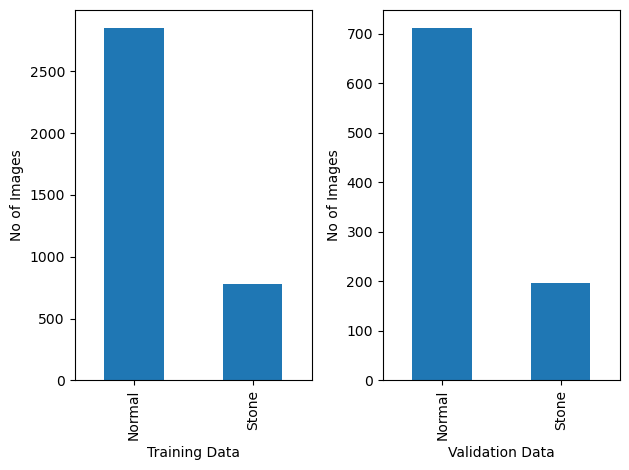

In [168]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

plt.subplot(1,2,1)
train_df['category'].value_counts().plot.bar()
plt.xlabel('Training Data')
plt.ylabel('No of Images')
plt.subplot(1,2,2)
validate_df['category'].value_counts().plot.bar()
plt.xlabel('Validation Data')
plt.ylabel('No of Images')
plt.tight_layout()
plt.show()

### Train and Validation generator

In [170]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "OneDrive/Documents/kidnee/CT_SCAN/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "OneDrive/Documents/kidnee/CT_SCAN/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)

Found 3632 validated image filenames belonging to 2 classes.
Found 908 validated image filenames belonging to 2 classes.


### Visulaizing the output of data gen

Found 1 validated image filenames belonging to 1 classes.


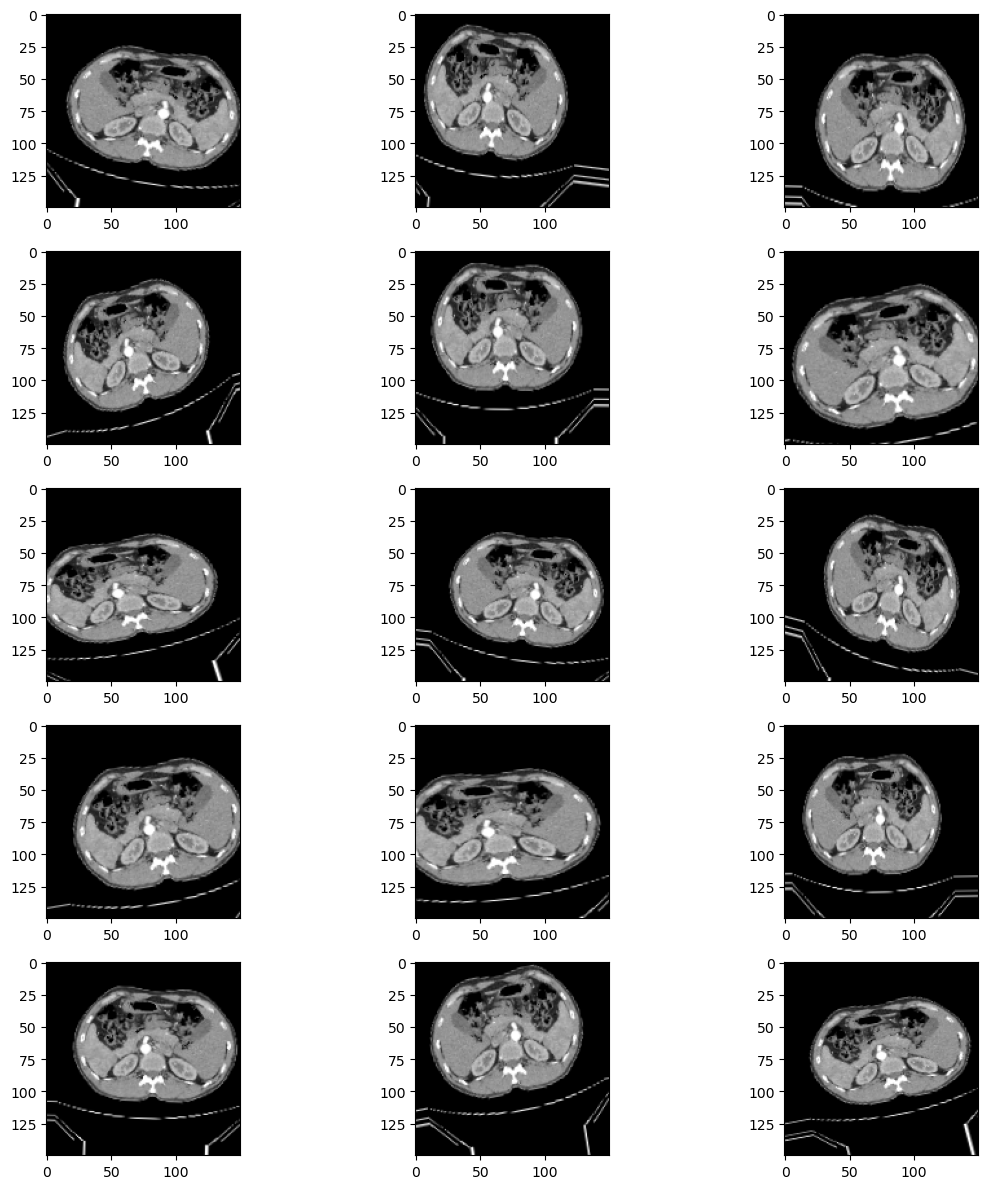

In [172]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "OneDrive/Documents/kidnee/CT_SCAN/Train/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fitting the Model

In [174]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [175]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

C:\Users\gaura\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 94s 380ms/step - accuracy: 0.6999 - loss: 0.6683 - val_accuracy: 0.7856 - val_loss: 5.8139 - learning_rate: 0.0010
Epoch 2/50
  1/242 ━━━━━━━━━━━━━━━━━━━━ 1:07 279ms/step - accuracy: 1.0000 - loss: 0.1938

C:\Users\gaura\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 1.0000 - loss: 0.1938 - val_accuracy: 0.7833 - val_loss: 5.8109 - learning_rate: 0.0010
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8516 - loss: 0.3555
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
242/242 ━━━━━━━━━━━━━━━━━━━━ 91s 375ms/step - accuracy: 0.8516 - loss: 0.3554 - val_accuracy: 0.4089 - val_loss: 4.5467 - learning_rate: 0.0010
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8000 - loss: 0.3996 - val_accuracy: 0.4078 - val_loss: 4.5315 - learning_rate: 5.0000e-04
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 91s 375ms/step - accuracy: 0.8929 - loss: 0.2901 - val_accuracy: 0.9222 - val_loss: 0.1590 - learning_rate: 5.0000e-04
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 1.0000 - loss: 0.0669 - val_accuracy: 0.9222 - val_loss: 0.1601 - learning_rate: 5.0000e-04
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 87s 361ms/step - accuracy: 0.8986 - l

### Visualizing the Training history

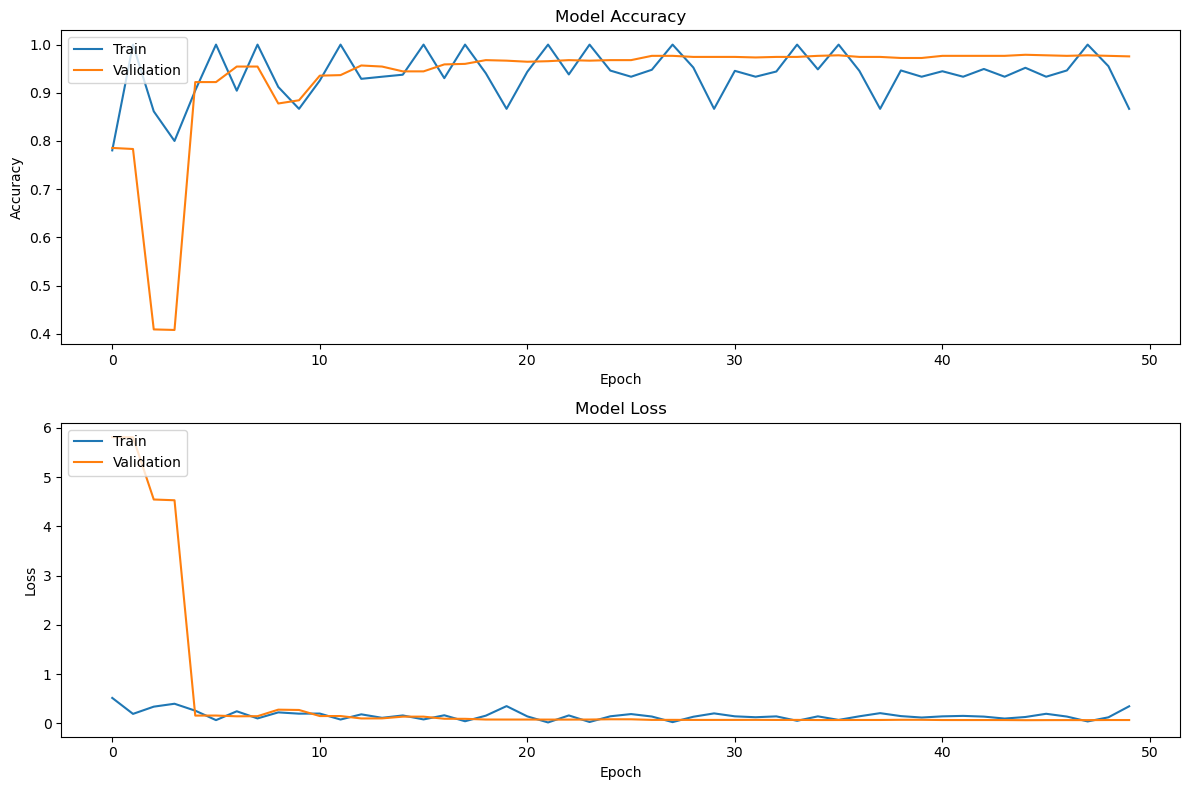

In [177]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Saving the CNN Model

In [179]:
model_save_path = 'OneDrive/Documents/kidnee/CT_SCAN/model.keras'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to OneDrive/Documents/kidnee/CT_SCAN/model.keras


### Testing Data

In [181]:
test_folder_path = "OneDrive/Documents/kidnee/CT_SCAN/Test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)

    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    "OneDrive/Documents/kidnee/CT_SCAN/Test/",
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 1914 validated image filenames belonging to 2 classes.


### Predictions

C:\Users\gaura\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step


,filename,category,predicted category
0,Normal\Normal- (1).jpg,Normal,Normal
1,Normal\Normal- (1001).jpg,Normal,Normal
2,Normal\Normal- (1002).jpg,Normal,Normal
3,Normal\Normal- (1003).jpg,Normal,Normal
4,Normal\Normal- (101).jpg,Normal,Normal


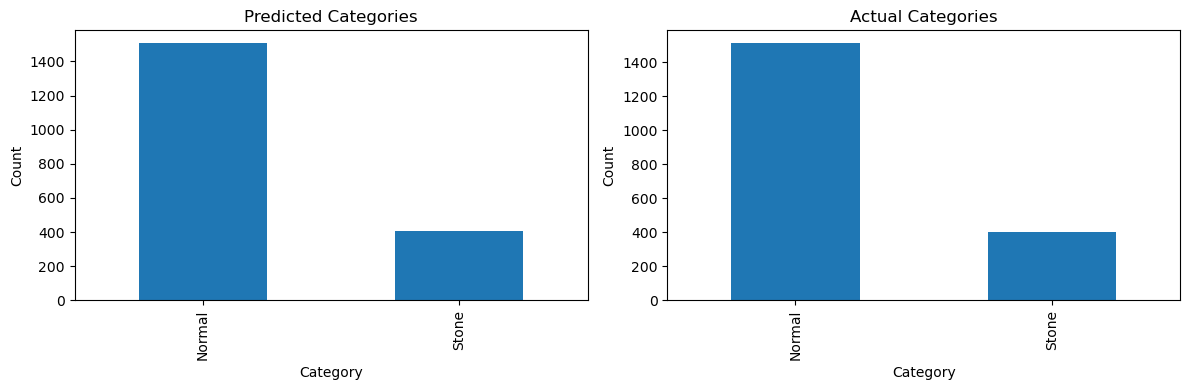

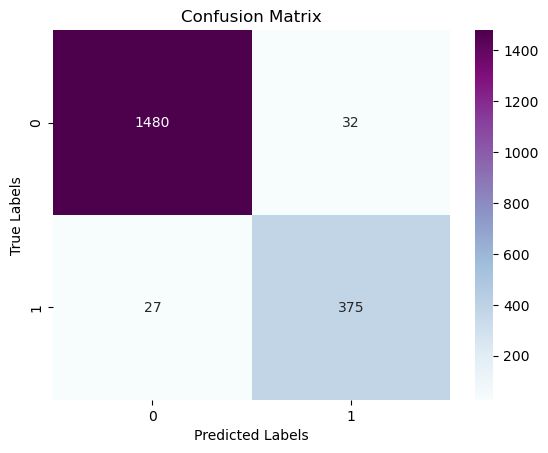

128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9857 - loss: 0.0544


[0.0791700929403305, 0.9691745042800903]

In [183]:
steps = int(np.ceil(test_df.shape[0] / 15))
predict = model.predict(test_generator, steps=steps)
test_df['predicted category'] = np.argmax(predict, axis=-1)
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })
display(test_df.head())
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

cm = confusion_matrix(test_df['category'], test_df['predicted category'])
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

model.evaluate(test_generator)

# SVM

#### SVM Feature Extraction

In [5]:
def read_images(path):
    images_list = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images_list.append(img)
    return images_list

train_normal = read_images('OneDrive/Documents/kidnee/CT_SCAN/Train/Normal')
train_stone = read_images('OneDrive/Documents/kidnee/CT_SCAN/Train/Stone') 

labels = ['Normal' for item in train_normal] + ['Stone' for item in train_stone]

def extract_features(images):
    feature_list = []
    for img in images:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True, channel_axis=2)
        fd = np.resize(fd, (2400, 1))
        fd = fd.flatten()
        feature_list.append(fd)
    return feature_list

feature_list_normal = extract_features(train_normal)
feature_list_stone = extract_features(train_stone) 
features = feature_list_normal + feature_list_stone

train_normal = read_images('OneDrive/Documents/kidnee/CT_SCAN/Train/Normal')
train_stone = read_images('OneDrive/Documents/kidnee/CT_SCAN/Train/Stone') 
labels = ['Normal' for item in train_normal] + ['Stone' for item in train_stone]

#### SVM Train/Test

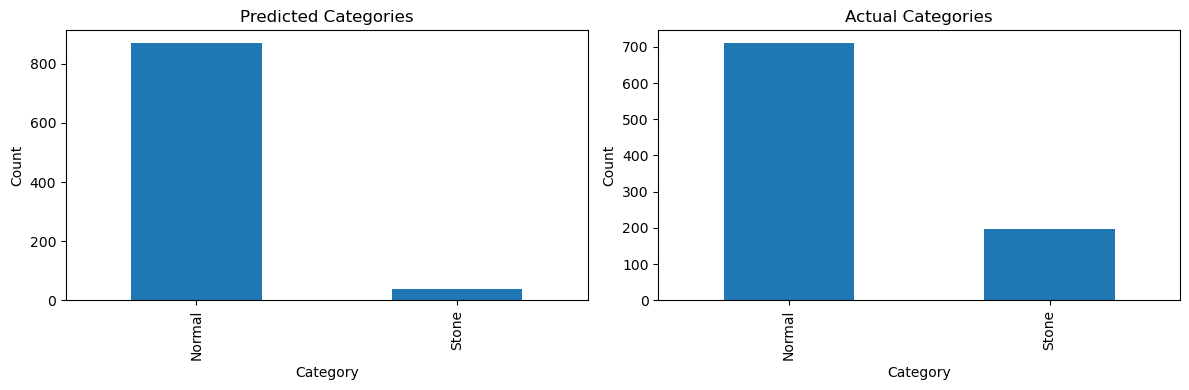

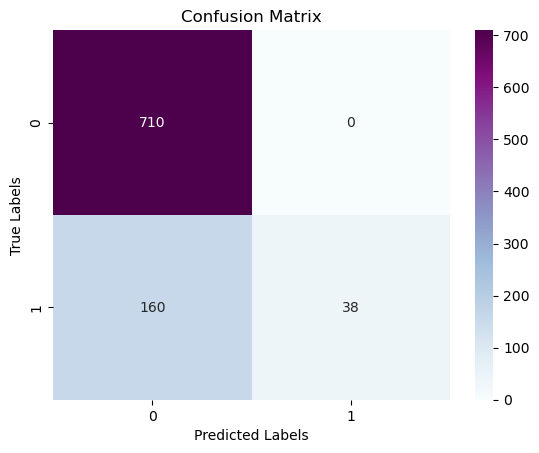

Accuracy :  0.8237885462555066


In [31]:
test_normal = read_images('OneDrive/Documents/kidnee/CT_SCAN/Test/Normal')
test_stone = read_images('OneDrive/Documents/kidnee/CT_SCAN/Test/Stone')
test_labels = ['Normal' for item in test_normal] + ['Stone' for item in test_stone] 

test_feature_list_normal = extract_features(test_normal)
test_feature_list_stone = extract_features(test_stone)

test_features = test_feature_list_normal + test_feature_list_stone 

X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=0) 

svc = SVC(kernel='rbf', C=1, gamma='auto')
svc.fit(X_train, y_train) 

y_pred = svc.predict(X_valid) 

accuracy = accuracy_score(y_valid, y_pred)

test_df = pd.DataFrame()
test_df['predicted category'] = np.array(y_pred)
test_df['category'] = y_valid
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

svm_cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy : ", accuracy) 

#### Saving the SVM Model

In [11]:
import sklearn.externals
import joblib
model_save_pathsvm = 'OneDrive/Documents/kidnee/CT_SCAN/svc.pkl'
print(f"Model saved to {model_save_pathsvm}")
joblib.dump(svc, model_save_pathsvm)

Model saved to OneDrive/Documents/kidnee/CT_SCAN/svc.pkl


['OneDrive/Documents/kidnee/CT_SCAN/svc.pkl']

# GUI

## tkinter GUI  

In [ ]:
import cv2
import numpy as np
from keras.preprocessing import image
from tkinter import filedialog, messagebox
from tkinter import *
import customtkinter
from PIL import Image, ImageTk
import joblib
from keras.models import load_model

cnn_model = load_model('OneDrive/Documents/kidnee/CT_SCAN/model.keras')  
svc_model = joblib.load("OneDrive/Documents/kidnee/CT_SCAN/svc.pkl")  

def extract_features(images):
    feature_list = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
        resized_img = cv2.resize(gray_img, (50, 48))
        flattened_img = resized_img.flatten()
        feature_list.append(flattened_img)
    return np.array(feature_list)

root = customtkinter.CTk()
root.geometry('420x380')
root.title('Kidney Stone Detection')

image_name = ""

label_cnn = customtkinter.CTkLabel(root, text="")
label_cnn.grid(row=1, column=1, sticky='nw', padx=20, pady=20)
label = customtkinter.CTkLabel(root, text="")
label.grid(row=2, column=1, sticky='nw', padx=20, pady=20)

def browse_btn():
    global image_name
    image_name = filedialog.askopenfilename(title='Select Image', filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.bmp;*.tiff")])

    if image_name:
        label_cnn.configure(text="")
        label.configure(text="")

        try:
            img = Image.open(image_name)
            img = img.resize((200, 200), Image.Resampling.LANCZOS)
            img = ImageTk.PhotoImage(img)
            panel = Label(root, image=img)
            panel.image = img
            panel.grid(row=0, column=1, sticky='nw', padx=20, pady=28)
        except Exception as e:
            messagebox.showerror("Error", f"Could not open or display image: {e}")

def predict_btn_combined():
    global label_cnn, label, image_name
    if not image_name:
        messagebox.showerror("Error", "Please select an image first.")
        return

    try:
        cnn_test_img = image.load_img(image_name, target_size=(150, 150))
        cnn_test_img = image.img_to_array(cnn_test_img)
        cnn_test_img = np.expand_dims(cnn_test_img, axis=0)  # Add batch dimension
        cnn_test_img = cnn_test_img / 255.0  # Normalize if needed
        cnn_result = cnn_model.predict(cnn_test_img)

        cnn_prediction = 1 if cnn_result[0][0] > 0.5 else 0
        test_img = cv2.imread(image_name)
        test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        features_for_svm = extract_features([test_img_rgb])
        svm_result = svc_model.predict(features_for_svm)
        svm_prediction = 1 if svm_result[0] == 'Stone' else 0

        final_prediction = 1 if cnn_prediction == 1 or svm_prediction == 1 else 0

        if final_prediction == 1:
            label.configure(text="Kidney Stone Detected", fg_color="red")
        else:
            label.configure(text="No Kidney Stone Detected", fg_color="green")

    except Exception as e:
        messagebox.showerror("Error", f"Prediction error: {e}")

browsebtn = customtkinter.CTkButton(master=root, text="Browse Image", command=browse_btn)
browsebtn.grid(row=0, column=0, sticky='nw', padx=20, pady=20)
predictbtn_combined = customtkinter.CTkButton(master=root, text="Predict Combined", command=predict_btn_combined)
predictbtn_combined.grid(row=1, column=0, sticky='nw', padx=20, pady=20)
root.mainloop() 

## Gradio APP

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
import joblib
from PIL import Image
import random

cnn_model = load_model('OneDrive/Documents/kidnee/CT_SCAN/model.keras')
svc_model = joblib.load("OneDrive/Documents/kidnee/CT_SCAN/svc.pkl")

def extract_features(images):
    feature_list = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        resized_img = cv2.resize(gray_img, (50, 48))
        flattened_img = resized_img.flatten()
        feature_list.append(flattened_img)
    return np.array(feature_list)

def estimate_stone_size():
    stone_size = round(random.uniform(0.5, 5.0), 2)
    return stone_size

def predict_combined(img):
    if img is None:
        return "Please upload an image."

    try:
        cnn_test_img = image.img_to_array(Image.fromarray(img).resize((150, 150)))
        cnn_test_img = np.expand_dims(cnn_test_img, axis=0)
        cnn_test_img = cnn_test_img / 255.0
        cnn_result = cnn_model.predict(cnn_test_img)
        cnn_prediction = 1 if cnn_result[0][0] > 0.5 else 0

        test_img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        features_for_svm = extract_features([test_img_rgb])
        svm_result = svc_model.predict(features_for_svm)
        svm_prediction = 1 if svm_result[0] == 'Stone' else 0

        if cnn_prediction == 1 or svm_prediction == 1:
            diagnosis = "Kidney Stone Detected (Positive)"
            probability = round(max(cnn_result[0][0], 0 if svm_prediction == 0 else 0.6), 2) # Basic way to estimate probability
            stone_size_cm = estimate_stone_size()
            stone_size = f"{stone_size_cm} cm"
            prescription = (
                "Consult a urologist. Suggested medications: pain relievers (e.g., ibuprofen, acetaminophen) and alpha blockers (e.g., tamsulosin). "
                "Drink plenty of water (2.5–3 liters per day). Consider dietary adjustments."
            )
            care_instructions = (
                "Follow the urologist's guidance and adhere to prescribed medication. Stay hydrated. "
                "If pain or urinary obstruction persists, surgical intervention may be recommended."
            )
            return (
                f"Diagnosis: {diagnosis}\n"
                f"Probability: {probability*100:.2f}%\n"
                f"Estimated Stone Size: {stone_size}\n"
                f"Prescription Guidance: {prescription}\n"
                f"Care Instructions: {care_instructions}"
            )
        else:
            diagnosis = "No Kidney Stone Detected (Negative)"
            probability = round(1 - max(cnn_result[0][0], 0 if svm_prediction == 1 else 0.6), 2) # Basic way to estimate probability
            return f"Diagnosis: {diagnosis}\nProbability: {probability*100:.2f}%"

    except Exception as e:
        return f"Error in prediction: {e}"

with gr.Blocks() as iface:
    gr.Markdown("# Kidney Stone Detection using Combined CNN and SVM")
    ct_image = gr.Image(label="Upload CT Image")

    combined_output = gr.Textbox(label="Prediction Result and Care Instructions")
    combined_predict_btn = gr.Button("Run Prediction")
    combined_predict_btn.click(fn=predict_combined, inputs=ct_image, outputs=combined_output)

iface.launch()